### Exploratory Data Analysis - 2023 Telstra Optus Route Leak

## Incident 
TBW**

## Data Download with BGPStream

```
 bgpreader -w '2023-11-08 12:00:00','2023-11-09 04:59:59' -o cache-dir=./cache -p ris -c rrc23 -t updates | tee 2023-telstra-optus-route-leak-ris-rrc23.csv
```

## Description of the Selected Features

The following features have been extracted from the BGP (Border Gateway Protocol) update messages contained in RIPE RIS MRT dumps and processed in configurable time windows:

1. **Feature 0: Total Number of BGP Update Messages**  
   - **Description**: The total count of all BGP update messages (both announcements and withdrawals) observed within each time window.  
   - **Use Case**: Provides a baseline measure of routing activity over time.  

2. **Feature 1: Number of BGP ANNOUNCEMENT Messages**  
   - **Description**: The total count of BGP `ANNOUNCEMENT` messages observed within each time window.  
   - **Use Case**: Tracks the frequency of new route announcements, indicating changes or additions in routing information.  

3. **Feature 2: Number of BGP WITHDRAWAL Messages**  
   - **Description**: The total count of BGP `WITHDRAWAL` messages observed within each time window.  
   - **Use Case**: Indicates how frequently routes are being removed or withdrawn, a potential indicator of network instability.  

4. **Feature 3: Average AS Path Length**  
   - **Description**: The average length of the Autonomous System (AS) path contained in BGP `ANNOUNCEMENT` messages for each time window.  
   - **Use Case**: Provides insights into routing path complexity and potential changes in routing policies.

5. **Feature 4: Median AS Path Length**  
   - **Description**: The median length of the Autonomous System (AS) path contained in BGP `ANNOUNCEMENT` messages for each time window.  
   - **Use Case**: A robust measure of central tendency for AS path lengths, less sensitive to outliers than the average.

6. **Feature 5: Number of Prefixes with AS Path Changes (Stable Origin AS)**  
   - **Description**: The count of prefixes where the AS path changes but the origin AS (last AS in the path) remains the same, observed within each time window.  
   - **Use Case**: Detects routing updates that modify paths without changing the origin, which could signal route optimization, policy changes, or anomalies.

## Plot Currently Identified Features

We load and consolidate the features we have identified. The consolidated features dataframe is saved in a separate CSV file.

In [1]:
%matplotlib widget

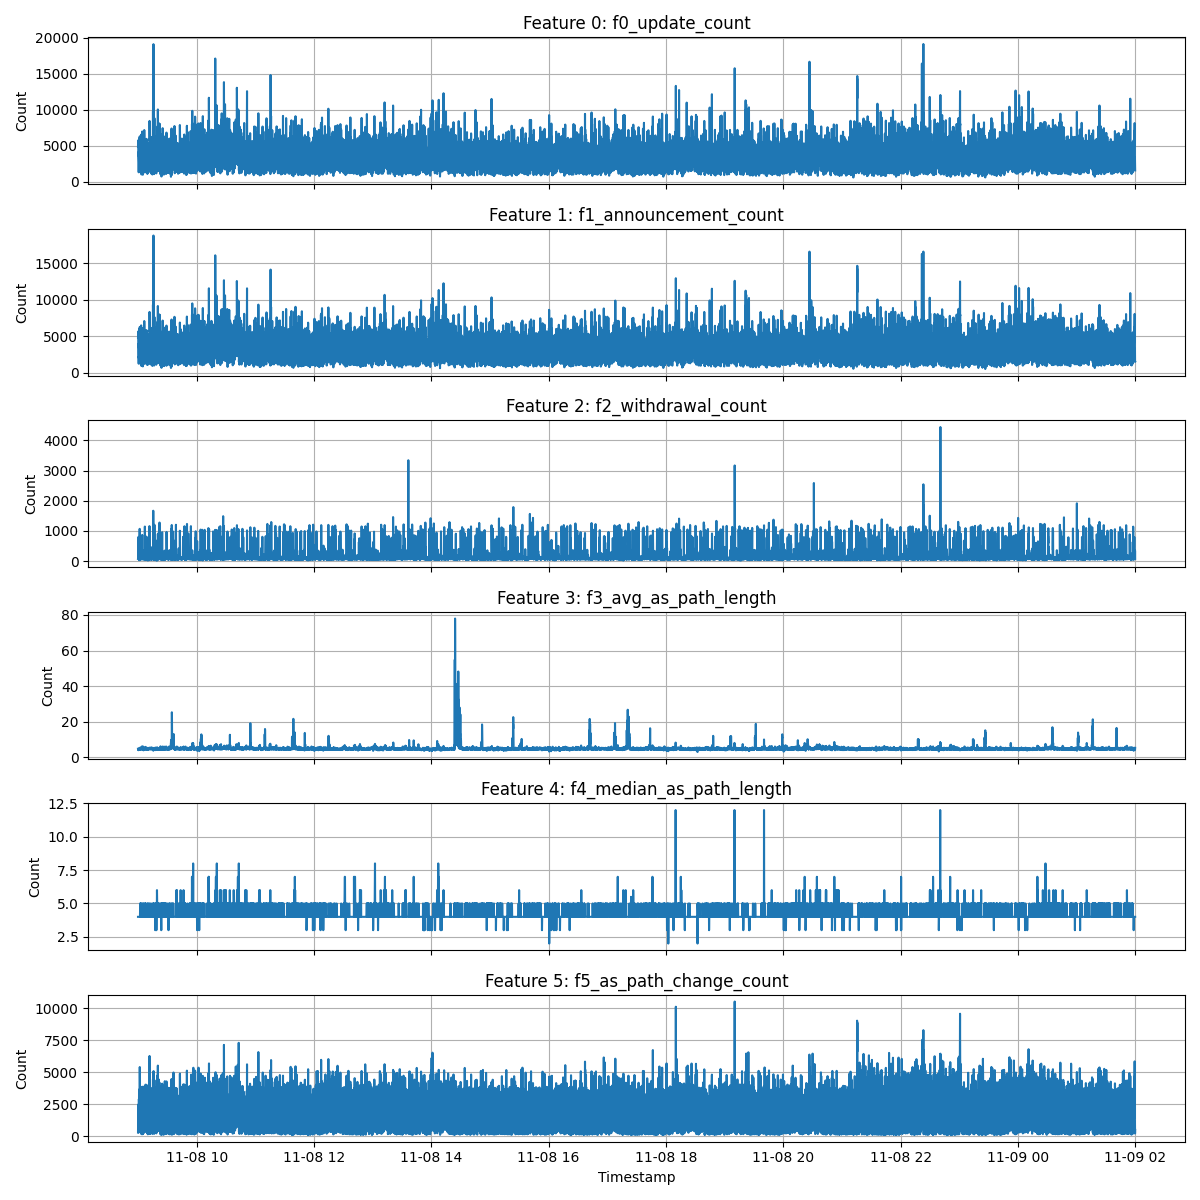

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

INCIDENT="2023-telstra-optus-leak"
WINDOW = "w06s"
# COLLECTOR="rrc11" ## Equinix NY
COLLECTOR="rrc23" ## Singapore
# File paths for the feature files
feature_0_file = f"../../features/{INCIDENT}/{WINDOW}/feature_0_{COLLECTOR}.csv"
feature_1_file = f"../../features/{INCIDENT}/{WINDOW}/feature_1_{COLLECTOR}.csv"
feature_2_file = f"../../features/{INCIDENT}/{WINDOW}/feature_2_{COLLECTOR}.csv"
feature_3_file = f"../../features/{INCIDENT}/{WINDOW}/feature_3_{COLLECTOR}.csv"
feature_4_file = f"../../features/{INCIDENT}/{WINDOW}/feature_4_{COLLECTOR}.csv"
feature_5_file = f"../../features/{INCIDENT}/{WINDOW}/feature_5_{COLLECTOR}.csv"

# Function to dynamically rename columns based on the feature name in the file
def load_and_rename(file_path, prefix):
    # Load the file
    df = pd.read_csv(file_path)
    # Extract the feature name (assuming it's consistent in the "feature_name" column)
    feature_name = df['feature_name'].iloc[0]
    # Rename the value column to include the prefix and feature name
    df = df.rename(columns={"timestamp": "timestamp", "value": f"{prefix}_{feature_name}"})
    # Drop the 'feature_name' column as it's no longer needed
    df = df.drop(columns=["feature_name"])
    return df

# Load and rename feature data
df_f0 = load_and_rename(feature_0_file, "f0")
df_f1 = load_and_rename(feature_1_file, "f1")
df_f2 = load_and_rename(feature_2_file, "f2")
df_f3 = load_and_rename(feature_3_file, "f3")
df_f4 = load_and_rename(feature_4_file, "f4")
df_f5 = load_and_rename(feature_5_file, "f5")

# Merge dataframes on 'timestamp'
merged_df = pd.merge(df_f0, df_f1, on="timestamp", how="outer")
merged_df = pd.merge(merged_df, df_f2, on="timestamp", how="outer")
merged_df = pd.merge(merged_df, df_f3, on="timestamp", how="outer")
merged_df = pd.merge(merged_df, df_f4, on="timestamp", how="outer")
merged_df = pd.merge(merged_df, df_f5, on="timestamp", how="outer")

# Fill missing values with 0
merged_df.fillna(0, inplace=True)

# Convert timestamp to datetime for better plotting
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Preview the merged dataframe
merged_df.head()

# Plotting
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot each feature dynamically
for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    ax.plot(merged_df['timestamp'], merged_df[col])
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Count")
    ax.grid(True)

# Add xlabel to the last subplot
axs[-1].set_xlabel("Timestamp")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Write the consolidated features file

We now output the consolidated features to a new CSV.

In [3]:
# Define the output file path
output_file1 = f"consolidated_features_{INCIDENT}_{COLLECTOR}_{WINDOW}.csv"
output_file2 = f"../../features/{INCIDENT}/{WINDOW}/consolidated_features_{COLLECTOR}.csv"

# Save the merged dataframe to a CSV file
merged_df.to_csv(output_file1, index=False)
print(f"Merged dataframe has been saved to: {output_file1}")


merged_df.to_csv(output_file2, index=False)
print(f"Merged dataframe has been saved to: {output_file2}")


Merged dataframe has been saved to: consolidated_features_2023-telstra-optus-leak_rrc23_w06s.csv
Merged dataframe has been saved to: ../../features/2023-telstra-optus-leak/w06s/consolidated_features_rrc23.csv


## Interactive plotting to visually identify anomalous time slots

In [4]:
merged_df.head()

,timestamp,f0_update_count,f1_announcement_count,f2_withdrawal_count,f3_avg_as_path_length,f4_median_as_path_length,f5_as_path_change_count
0,2023-11-08 09:00:00,4867,4788,79,4.883250,4.0,281
1,2023-11-08 09:00:06,5737,5639,98,4.478986,4.0,2061
2,2023-11-08 09:00:12,4639,4524,114,4.415561,4.0,2467
3,2023-11-08 09:00:18,3696,3601,94,4.078867,4.0,1404
4,2023-11-08 09:00:24,3338,2532,805,4.648894,4.0,1298


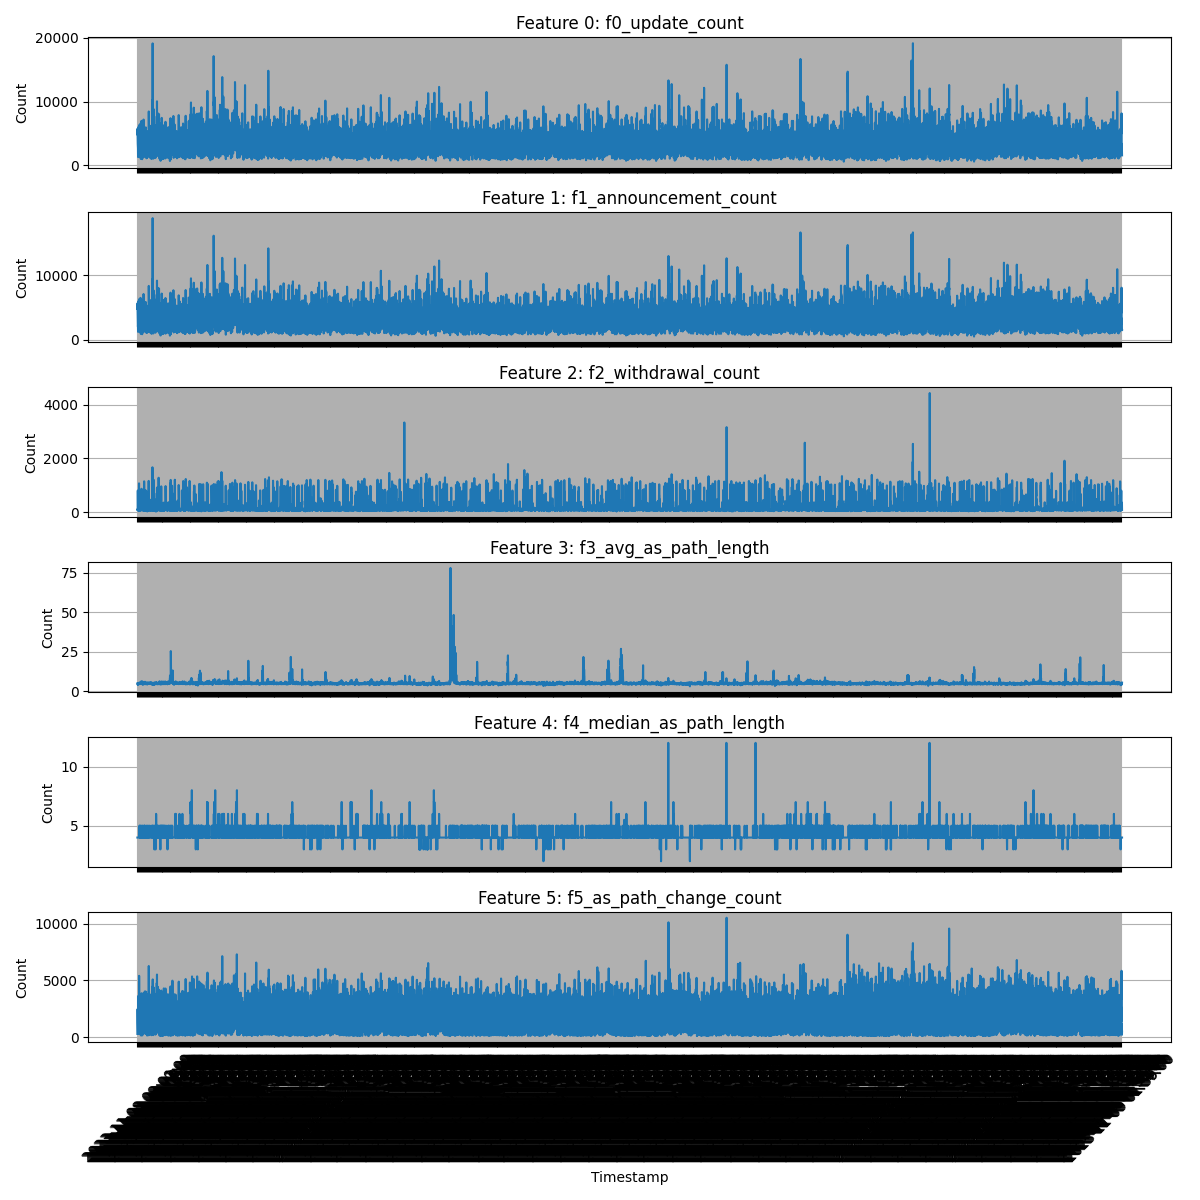

Selected regions: []


In [6]:
# Enable the interactive Matplotlib backend
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from IPython.display import display

# List to store selected regions
selected_regions = []

# Callback function to handle rectangle selection
def onselect(eclick, erelease):
    # Get the start and end timestamps of the selection
    start = eclick.xdata
    end = erelease.xdata
    selected_regions.append((start, end))
    display(f"Selected region: Start={start}, End={end}")

# Plot the data
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    ax.plot(merged_df['timestamp'], merged_df[col])
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Count")
    ax.grid(True)
    ax.tick_params(axis="x", rotation=45)  # Rotate X-axis labels for readability

# Set X-axis ticks and labels
axs[-1].set_xlabel("Timestamp")
axs[-1].set_xticks(merged_df['timestamp'][::10])  # Set every 10th tick (adjust for density)
axs[-1].set_xticklabels(merged_df['timestamp'][::10].dt.strftime('%Y-%m-%d %H:%M:%S'))

# Enable RectangleSelector on the last subplot (or extend to others)
rectangle_selector = RectangleSelector(axs[-1], onselect,
                                       useblit=True,
                                       button=[1],  # Left mouse button
                                       interactive=True)

plt.tight_layout()
plt.show()

# After closing the plot
print("Selected regions:", selected_regions)
